In [1]:
import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import src.eda
from src.eda import calculate_vif

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
import shap

## Model 1: Linear Regression

In [3]:
df_lr = pd.read_csv("../data/df_LR.csv")

In [4]:
df_lr.head()

,cleaning_fee_log,bedroom_group,min_stay_group,guest_capacity,nightly_rate_log,amenities_count,property_type_Standard Apartment,property_type_Tiny Studio,host_response_time_same day,host_response_time_within an hour,season_peak,season_shoulder,cancellation_policy_moderate,cancellation_policy_strict
0,3.110399,1,1,4,5.237983,8,1,0,0,1,1,0,0,0
1,3.671225,1,1,3,5.547674,6,1,0,0,0,0,0,0,0
2,3.938470,0,0,2,4.156067,10,1,0,1,0,0,0,0,0
3,3.593744,1,1,2,5.322034,11,1,0,1,0,0,1,0,1
4,2.895912,0,0,3,4.976803,7,0,1,0,0,0,1,0,1


In [5]:
X = df_lr.drop(columns=["nightly_rate_log"])
y = df_lr["nightly_rate_log"]
X = sm.add_constant(X)
X = X.astype(float)

In [6]:
# Build model

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       nightly_rate_log   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     189.2
Date:                Tue, 06 May 2025   Prob (F-statistic):               0.00
Time:                        12:19:07   Log-Likelihood:                -2477.0
No. Observations:                3854   AIC:                             4982.
Df Residuals:                    3840   BIC:                             5070.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

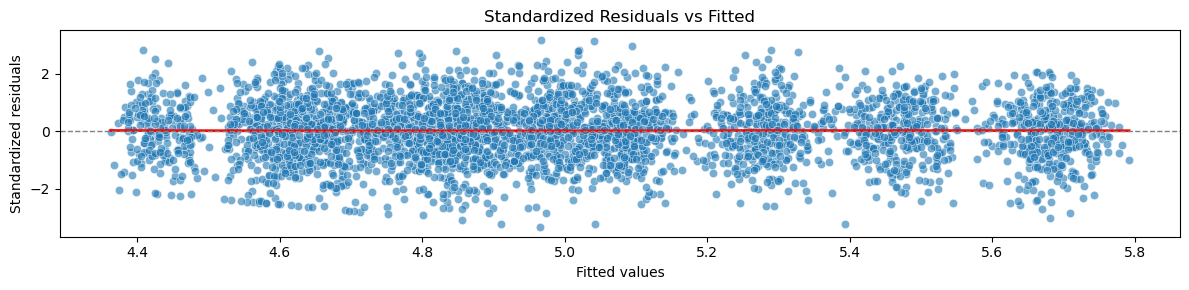

<Figure size 1200x300 with 0 Axes>

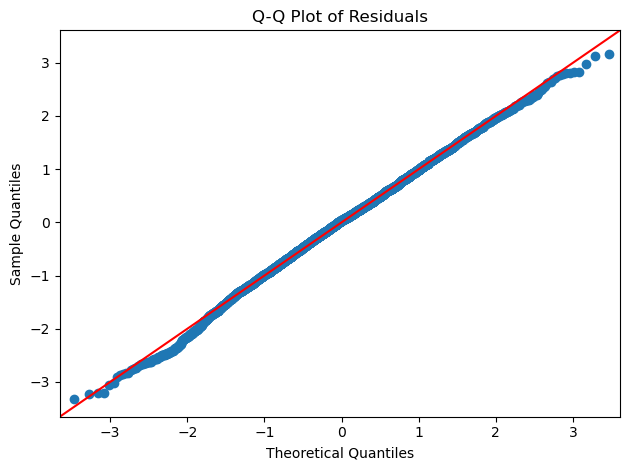

In [7]:
def plot_diagnostics(model, figsize=(12, 6)):

    resid  = model.resid
    fitted = model.fittedvalues

    stand_resid = (resid - np.mean(resid)) / np.std(resid)

    # 1. Residuals vs Fitted
    plt.figure(figsize=(figsize[0], figsize[1] // 2))
    sns.scatterplot(x=fitted, y=stand_resid, alpha=0.6)
    sns.regplot(x=fitted, y=stand_resid,
                scatter=False, lowess=True,
                line_kws={'color':'red', 'lw':2})
    plt.axhline(0, linestyle='--', color='grey', lw=1)
    plt.xlabel("Fitted values")
    plt.ylabel("Standardized residuals")
    plt.title("Standardized Residuals vs Fitted")
    plt.tight_layout()
    plt.show()

    # 2. Q–Q Plot
    plt.figure(figsize=(figsize[0], figsize[1] // 2))
    sm.qqplot(resid, line='45', fit=True)
    plt.title("Q-Q Plot of Residuals")
    plt.tight_layout()
    plt.show()
    
plot_diagnostics(model)


In [8]:
calculate_vif(X, X.columns)

,feature,VIF
0,const,243.555142
7,property_type_Tiny Studio,10.550660
6,property_type_Standard Apartment,7.923828
2,bedroom_group,6.774575
1,cleaning_fee_log,3.157251
8,host_response_time_same day,3.105269
9,host_response_time_within an hour,3.101753
4,guest_capacity,2.919759
3,min_stay_group,2.142582
5,amenities_count,1.497626


In [9]:
df_lr.head()

,cleaning_fee_log,bedroom_group,min_stay_group,guest_capacity,nightly_rate_log,amenities_count,property_type_Standard Apartment,property_type_Tiny Studio,host_response_time_same day,host_response_time_within an hour,season_peak,season_shoulder,cancellation_policy_moderate,cancellation_policy_strict
0,3.110399,1,1,4,5.237983,8,1,0,0,1,1,0,0,0
1,3.671225,1,1,3,5.547674,6,1,0,0,0,0,0,0,0
2,3.938470,0,0,2,4.156067,10,1,0,1,0,0,0,0,0
3,3.593744,1,1,2,5.322034,11,1,0,1,0,0,1,0,1
4,2.895912,0,0,3,4.976803,7,0,1,0,0,0,1,0,1


In [10]:
# Add interaction term
df_lr['room_capacity'] = df_lr['guest_capacity'] * df_lr['bedroom_group']
df_lr['amenities_clean_fee'] = df_lr['amenities_count'] * df_lr['cleaning_fee_log']

X_inter = df_lr.drop(columns=["nightly_rate_log", "guest_capacity", "bedroom_group", "cleaning_fee_log", "amenities_count"])
y_inter = df_lr["nightly_rate_log"]


X_inter = sm.add_constant(X_inter.astype(float))
model_inter= sm.OLS(y_inter, X_inter).fit()

print(model_inter.summary())


y_inter_pred = model_inter.predict(X_inter)
mae_log = mean_absolute_error(y_inter, y_inter_pred)
print(f"MAE (log space): {mae_log:.4f}")

                            OLS Regression Results                            
Dep. Variable:       nightly_rate_log   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     223.3
Date:                Tue, 06 May 2025   Prob (F-statistic):               0.00
Time:                        12:19:08   Log-Likelihood:                -2478.2
No. Observations:                3854   AIC:                             4980.
Df Residuals:                    3842   BIC:                             5055.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

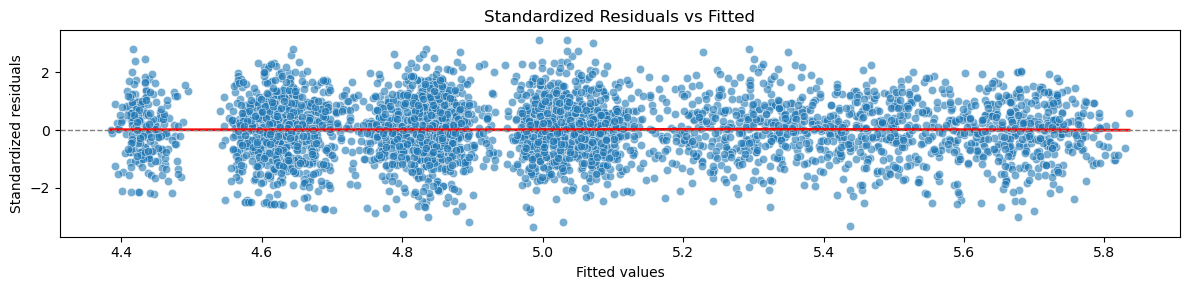

<Figure size 1200x300 with 0 Axes>

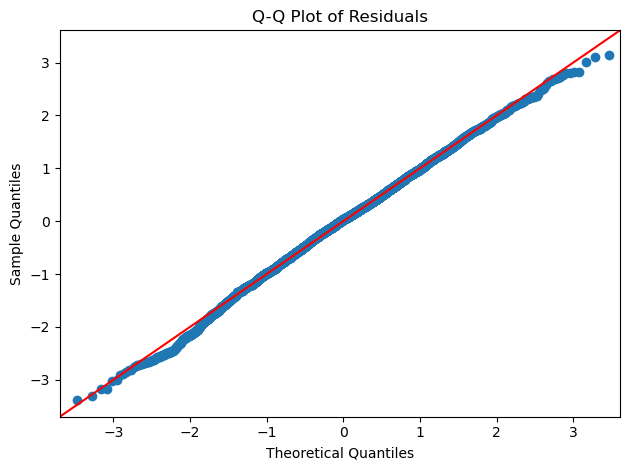

In [11]:
plot_diagnostics(model_inter)

In [12]:
calculate_vif(X_inter, X_inter.columns)

,feature,VIF
0,const,67.657291
2,property_type_Standard Apartment,8.293079
3,property_type_Tiny Studio,8.222603
10,room_capacity,7.192033
4,host_response_time_same day,3.099205
5,host_response_time_within an hour,3.094956
1,min_stay_group,2.139627
11,amenities_clean_fee,2.106795
6,season_peak,1.407136
7,season_shoulder,1.404098


## Model 2: Decision Tree Model

In [26]:
df_tree = pd.read_csv('../data/df_tree.csv')

In [27]:
df_tree.columns

Index(['number_of_bedrooms', 'guest_capacity', 'location_score',
       'review_score', 'amenities_count', 'minimum_stay_nights',
       'years_as_host', 'cleaning_fee', 'nightly_rate', 'bedroom_group',
       'min_stay_group', 'years_as_host_log', 'cleaning_fee_log',
       'nightly_rate_log', 'property_type_Standard Apartment',
       'property_type_Tiny Studio', 'host_response_time_same day',
       'host_response_time_within an hour', 'season_peak', 'season_shoulder',
       'cancellation_policy_moderate', 'cancellation_policy_strict'],
      dtype='object')

In [28]:
X = df_tree.drop(columns=['nightly_rate_log', 'nightly_rate'])
y = df_tree['nightly_rate_log']

In [29]:
X.columns

Index(['number_of_bedrooms', 'guest_capacity', 'location_score',
       'review_score', 'amenities_count', 'minimum_stay_nights',
       'years_as_host', 'cleaning_fee', 'bedroom_group', 'min_stay_group',
       'years_as_host_log', 'cleaning_fee_log',
       'property_type_Standard Apartment', 'property_type_Tiny Studio',
       'host_response_time_same day', 'host_response_time_within an hour',
       'season_peak', 'season_shoulder', 'cancellation_policy_moderate',
       'cancellation_policy_strict'],
      dtype='object')

In [30]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Build model
tree_model = DecisionTreeRegressor(max_depth=4, min_samples_leaf=20,  random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=20, random_state=42)

In [32]:
# Evaluation

y_pred = tree_model.predict(X_test)
print("R2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

R2: 0.37744215021886784
MAE: 0.37158768289694294


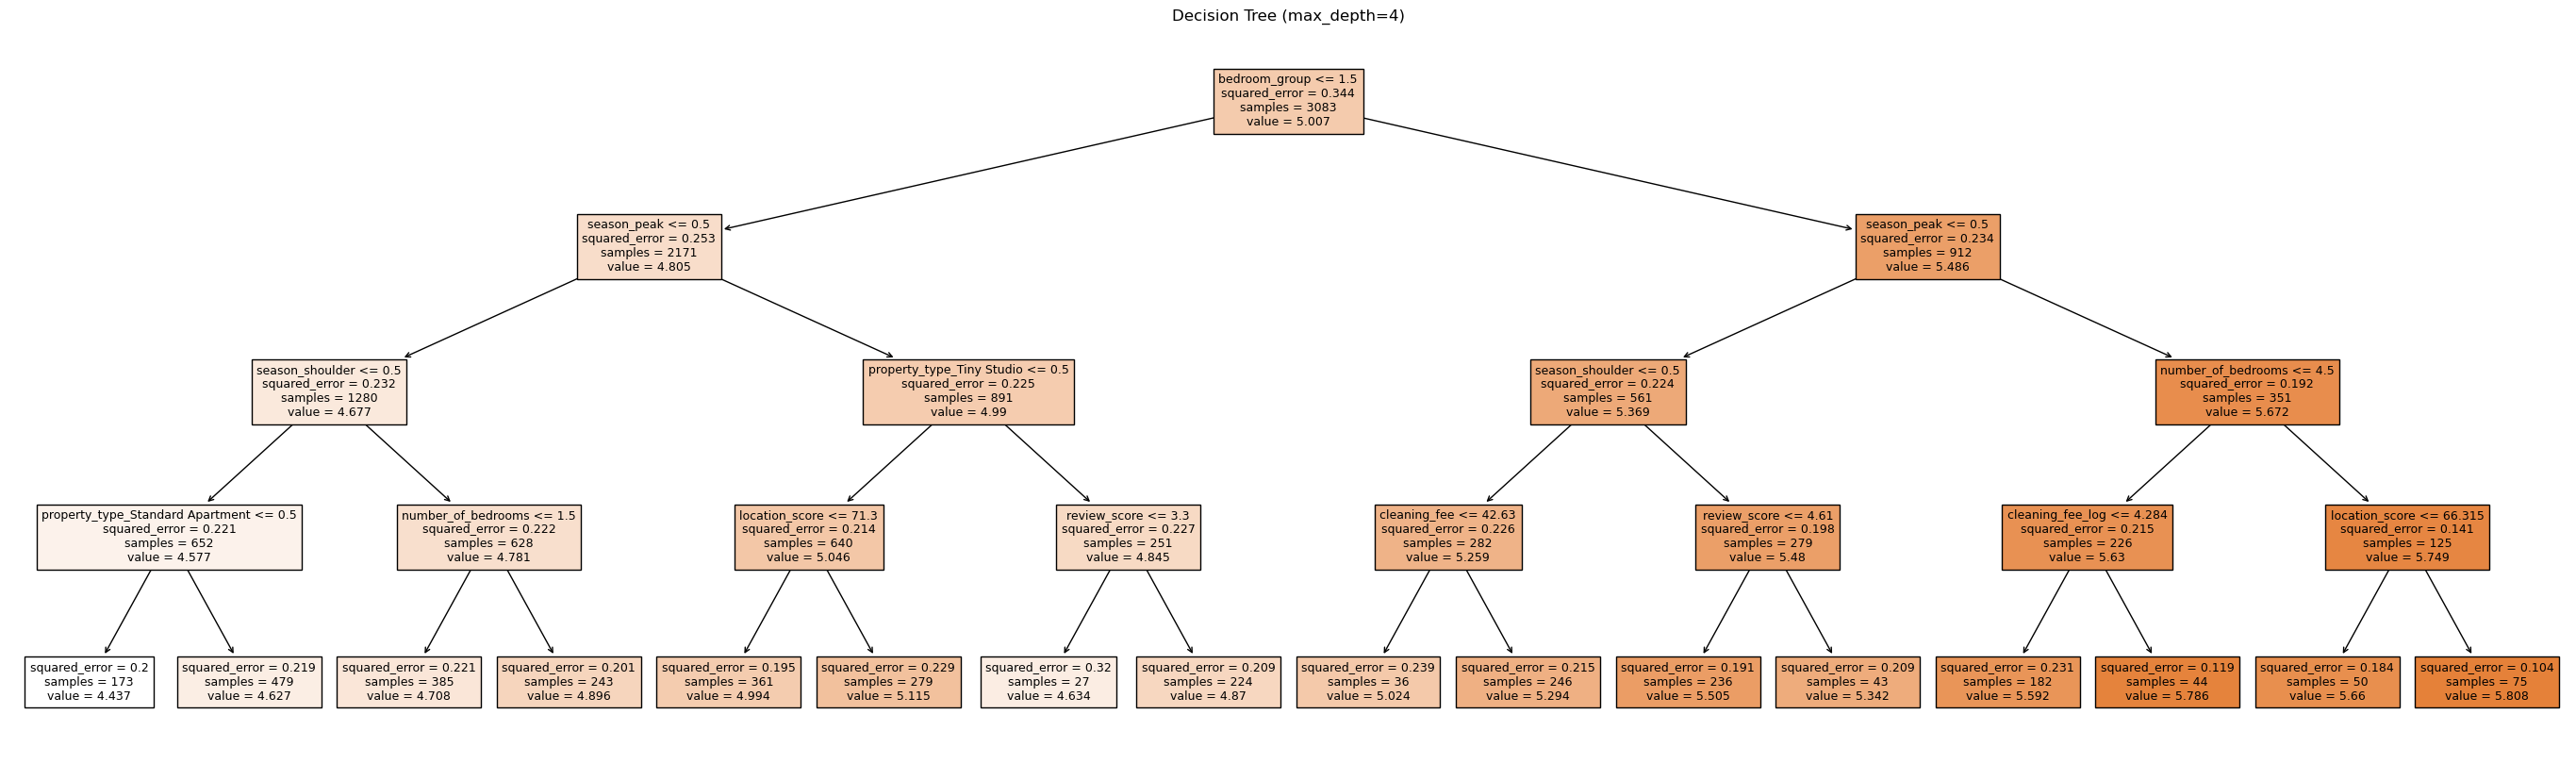

In [33]:
plt.figure(figsize=(35, 10))
plot_tree(tree_model, feature_names=X.columns, filled=True, fontsize=9)
plt.title("Decision Tree (max_depth=4)")
plt.show()

## Model Interpretation and Explanation

### Global Explanation - Feature Importance

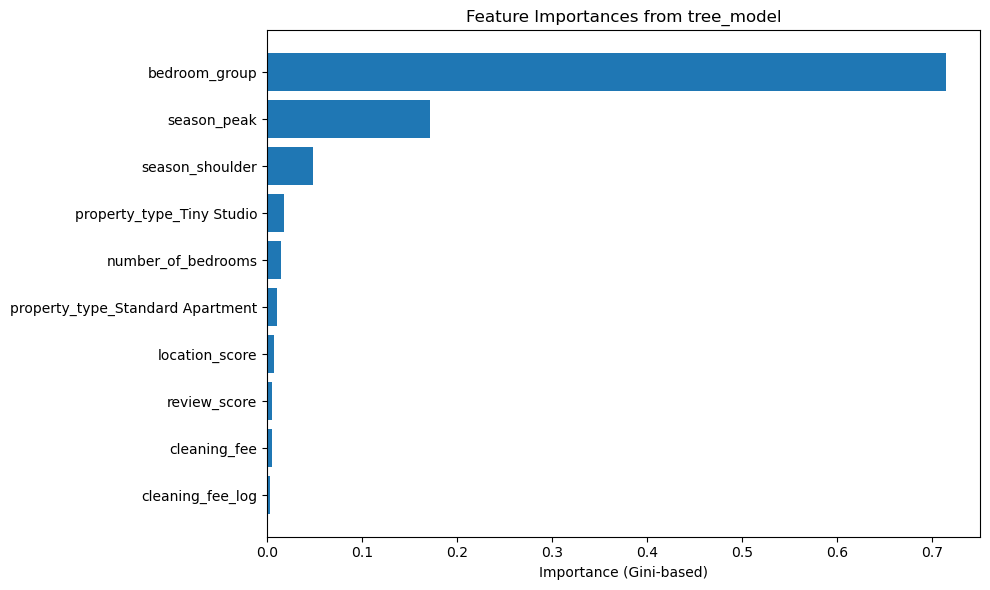

In [34]:
fi_values = tree_model.feature_importances_

fi_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': fi_values
}).sort_values(by='Importance', ascending=False)

fi_top10 = fi_df.head(10)

plt.figure(figsize=(10, 6))
plt.barh(fi_top10['Feature'][::-1], fi_top10['Importance'][::-1])
plt.title("Feature Importances from tree_model")
plt.xlabel("Importance (Gini-based)")
plt.tight_layout()
plt.show()

### Local Explanation - SHAP

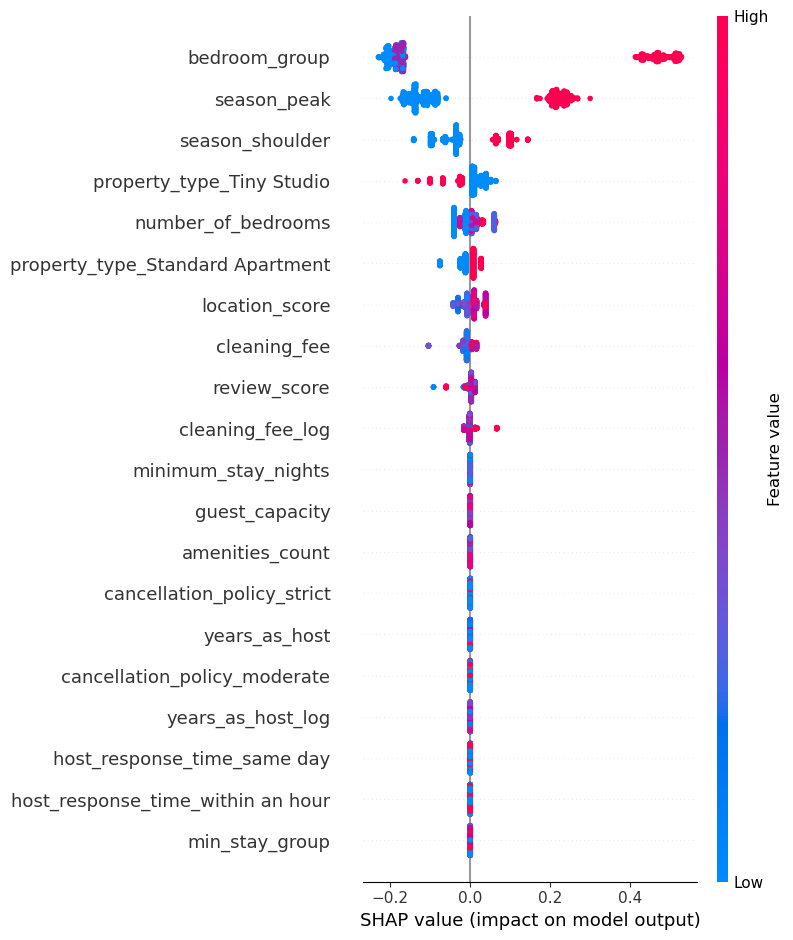

In [35]:
# SHAP summary report

explainer = shap.TreeExplainer(tree_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

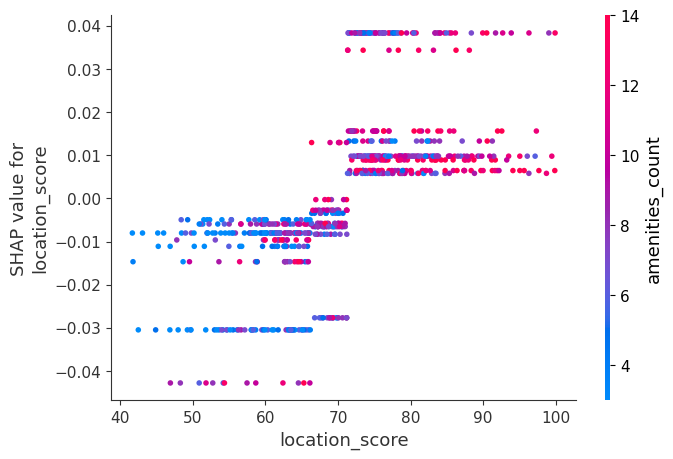

In [36]:
# Dependence plot
shap.dependence_plot("location_score", shap_values, X_test, interaction_index= "amenities_count")
